In [ ]:


import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
!pip install opencv-python


In [3]:
!pip install keras

In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Required libraries
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# TensorFlow/Keras imports
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121


In [5]:
import os
import pandas as pd

data_train = []
type_of_disease = ['COVID-19', 'Non-COVID-19']  # Match folder names exactly
data_directory = r'C:\Users\beeoi\Desktop\data science\COVID-19_Lung_CT_Scans'  # Use raw string for paths
train_directory = os.path.join(data_directory)

for id, sp in enumerate(type_of_disease):
    disease_path = os.path.join(train_directory, sp)
    if not os.path.exists(disease_path):
        raise FileNotFoundError(f"Directory does not exist: {disease_path}")
    
    for file in os.listdir(disease_path):
        data_train.append([f'{sp}/{file}', id, sp])

train = pd.DataFrame(data_train, columns=['Image', 'Id of Disease', 'Type of Disease'])

# Display the first few rows
print(train.head())


                        Image  Id of Disease Type of Disease
0  COVID-19/COVID-19_0001.png              0        COVID-19
1  COVID-19/COVID-19_0002.png              0        COVID-19
2  COVID-19/COVID-19_0003.png              0        COVID-19
3  COVID-19/COVID-19_0004.png              0        COVID-19
4  COVID-19/COVID-19_0005.png              0        COVID-19


In [6]:
train.head()

,Image,Id of Disease,Type of Disease
0,COVID-19/COVID-19_0001.png,0,COVID-19
1,COVID-19/COVID-19_0002.png,0,COVID-19
2,COVID-19/COVID-19_0003.png,0,COVID-19
3,COVID-19/COVID-19_0004.png,0,COVID-19
4,COVID-19/COVID-19_0005.png,0,COVID-19


In [7]:
#make the order of training set randomize
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))

In [8]:
train.head()

,Image,Id of Disease,Type of Disease
0,COVID-19/image_3406.png,0,COVID-19
1,COVID-19/image_2959.png,0,COVID-19
2,COVID-19/COVID-19_4171.png,0,COVID-19
3,Non-COVID-19/Non-COVID-19_186.png,1,Non-COVID-19
4,COVID-19/image_5445.png,0,COVID-19


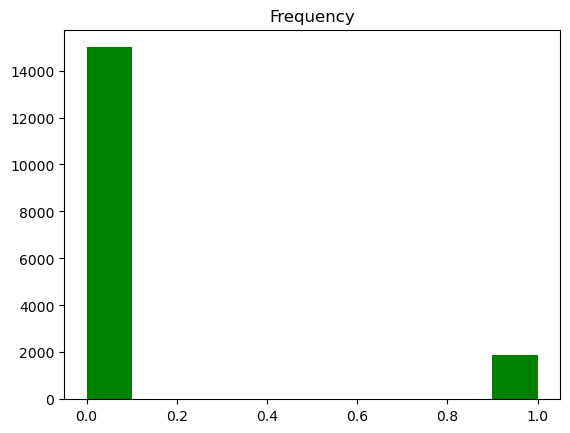

In [9]:
#checking with plot to understand the frequency of histogram 
plt.hist(train['Id of Disease'],color = "green")
plt.title('Frequency')
plt.show()

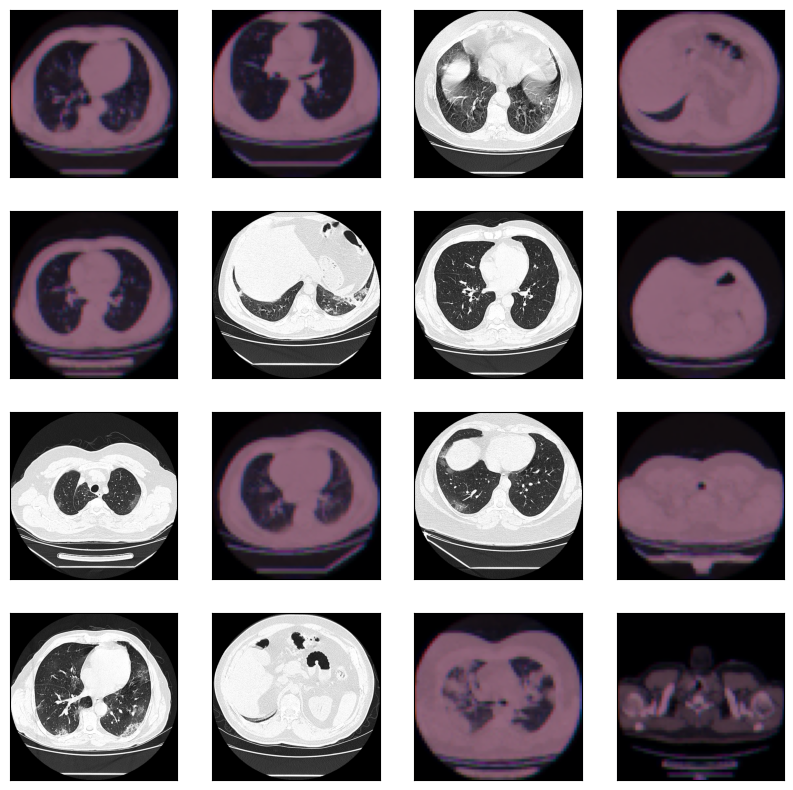

In [10]:
#creating a function which shows the images of the covid

def show_covid_images(disease_type, r, c):
    fig,ax = plt.subplots(r,c, figsize=(10,10))
    disease_image = train['Image'][train['Type of Disease'] == disease_type].values
    n = 0
    for i in range(r):
        for j in range(c):
            image = os.path.join(data_directory, disease_image[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image))
            n += 1
            
show_covid_images('COVID-19',4,4) 

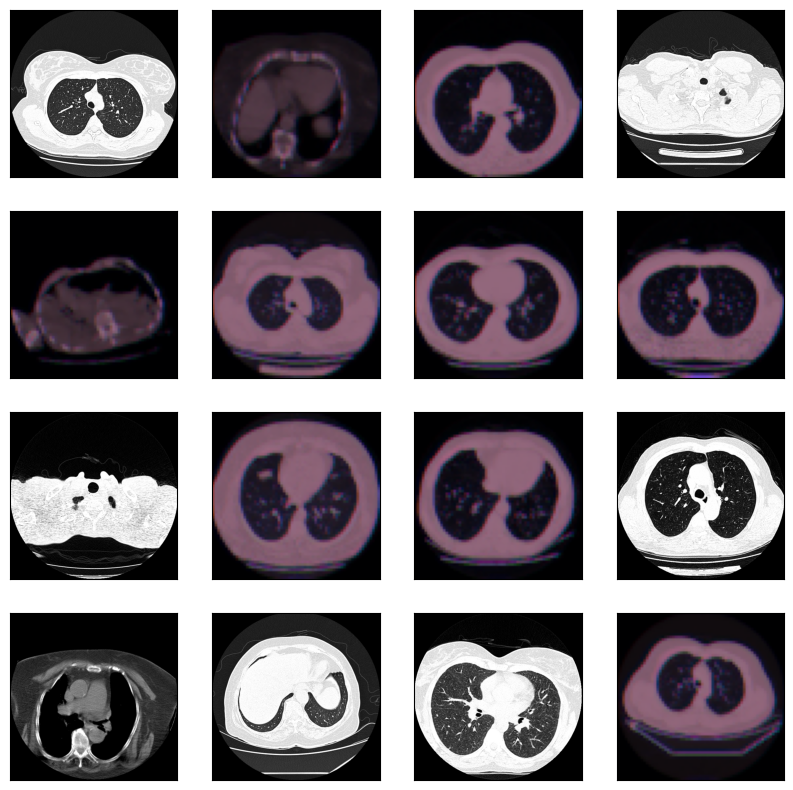

In [11]:
# creating a function which shows non-covid images
def show_non_covid_images(disease_type, r, c):
    fig,ax = plt.subplots(r,c, figsize=(10,10))
    disease_image = train['Image'][train['Type of Disease'] == disease_type].values
    n = 0
    for i in range(r):
        for j in range(c):
            image = os.path.join(data_directory, disease_image[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image))
            n += 1
            
show_non_covid_images('Non-COVID-19',4,4)  

In [12]:
SIZE_OF_IMAGE = 128
def read_image(imagepath):
    return cv2.imread(os.path.join(data_directory, imagepath))

def resize_image(image, image_Size):
    return cv2.resize(image.copy(), image_Size, interpolation=cv2.INTER_AREA)

In [13]:
#training images

x_train = np.zeros((train.shape[0], SIZE_OF_IMAGE, SIZE_OF_IMAGE, 3))

for i, file in tqdm(enumerate(train['Image'].values)):
    image = read_image(file)
    
    if image is not None:
        x_train[i] = resize_image(image,(SIZE_OF_IMAGE, SIZE_OF_IMAGE))
        
X_Train = x_train / 255
print('Train shape: {}'.format(X_Train.shape))

16879it [00:55, 306.01it/s]


Train shape: (16879, 128, 128, 3)


In [14]:
#conerting labels to Categorical
y_train = train['Id of Disease'].values
y_train = to_categorical(y_train, num_classes=2)

In [15]:
#train and tes splitting
BATCH_SIZE = 64

X_train, X_test, Y_train, Y_test = train_test_split(X_Train,y_train, test_size=0.2, random_state=SEED)

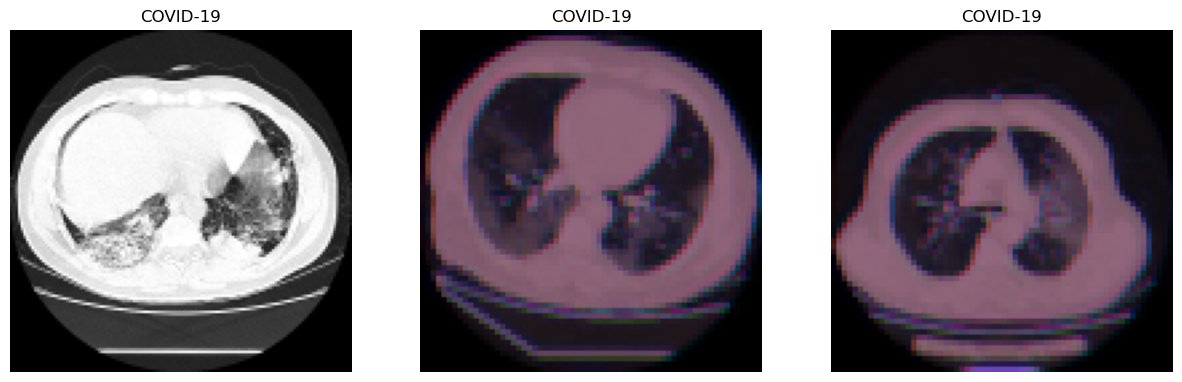

In [16]:
#training_images
fig, ax = plt.subplots(1,3, figsize=(15,15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(type_of_disease[np.argmax(Y_train[i])])

In [17]:
EPOCHS = 50
SIZE=128
N_ch=3

In [18]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    # Define input layer
    input = Input(shape=(SIZE, SIZE, N_ch))  # Ensure SIZE and N_ch are defined elsewhere

    # Add preprocessing layer to ensure input matches DenseNet expected shape
    x = Conv2D(3, (3, 3), padding='same')(input)

    # Add DenseNet base
    x = densenet(x)

    # Add global pooling, batch normalization, dropout, and dense layers
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Final output layer with softmax activation for 2 classes
    output = Dense(2, activation='softmax', name='root')(x)

    # Define model
    model = Model(input, output)

    # Compile model
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint('model.keras', verbose=1, save_best_only=True)  # Use .keras extension
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

# Model Training
model = build_densenet()
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=30,
    verbose=2,
    callbacks=[checkpoint, annealer],
    validation_data=(X_test, Y_test)
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,622 (27.87 MB)

 Trainable params: 7,219,414 (27.54 MB)

 Non-trainable params: 86,208 (336.75 KB)

c:\Users\beeoi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.27601, saving model to model.keras
210/210 - 453s - 2s/step - accuracy: 0.6396 - loss: 0.8553 - val_accuracy: 0.9174 - val_loss: 0.2760 - learning_rate: 0.0020
Epoch 2/30


c:\Users\beeoi\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_loss improved from 0.27601 to 0.27601, saving model to model.keras
210/210 - 24s - 116ms/step - accuracy: 0.7656 - loss: 0.4709 - val_accuracy: 0.9165 - val_loss: 0.2760 - learning_rate: 0.0020
Epoch 3/30

Epoch 3: val_loss improved from 0.27601 to 0.20688, saving model to model.keras
210/210 - 335s - 2s/step - accuracy: 0.8440 - loss: 0.3859 - val_accuracy: 0.9307 - val_loss: 0.2069 - learning_rate: 0.0020
Epoch 4/30

Epoch 4: val_loss improved from 0.20688 to 0.20316, saving model to model.keras
210/210 - 25s - 118ms/step - accuracy: 0.8750 - loss: 0.2867 - val_accuracy: 0.9316 - val_loss: 0.2032 - learning_rate: 0.0020
Epoch 5/30

Epoch 5: val_loss improved from 0.20316 to 0.15787, saving model to model.keras
210/210 - 334s - 2s/step - accuracy: 0.9197 - loss: 0.2511 - val_accuracy: 0.9479 - val_loss: 0.1579 - learning_rate: 0.0020
Epoch 6/30

Epoch 6: val_loss did not improve from 0.15787
210/210 - 22s - 106ms/step - accuracy: 0.9688 - loss: 0.1633 - val_accuracy: 0.9

106/106 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step


Text(0.5, 155.72222222222217, 'Predicted')

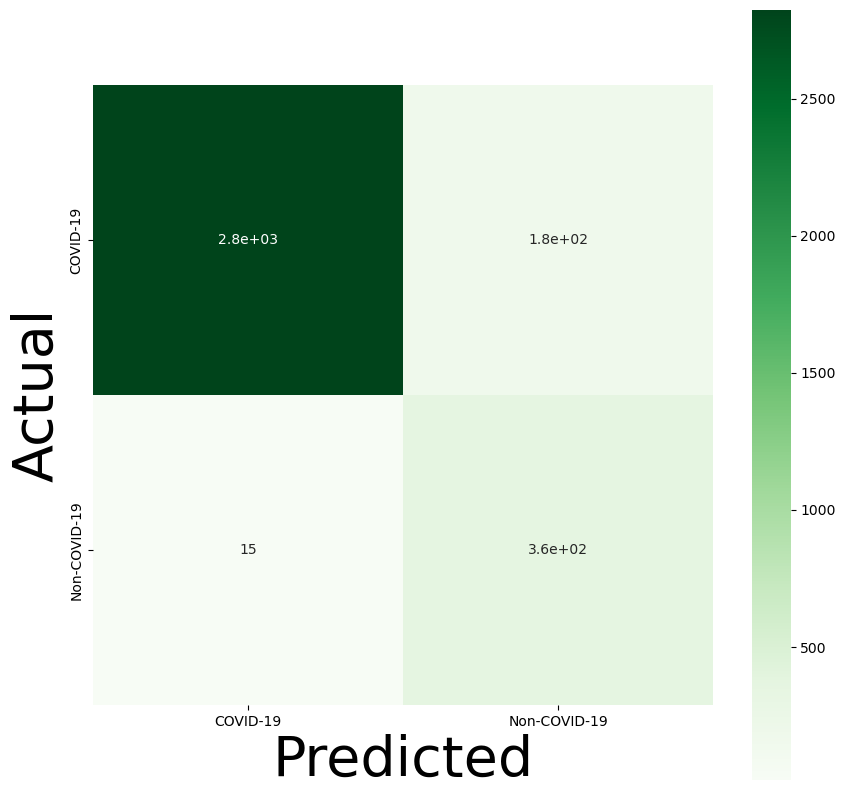

In [26]:
#confusion matrix
Y_predict = model.predict(X_test)
Y_predict = np.argmax(Y_predict, axis= 1)
Y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_true, Y_predict)
plt.figure(figsize=(10,10))
ax= sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=type_of_disease,yticklabels=type_of_disease)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

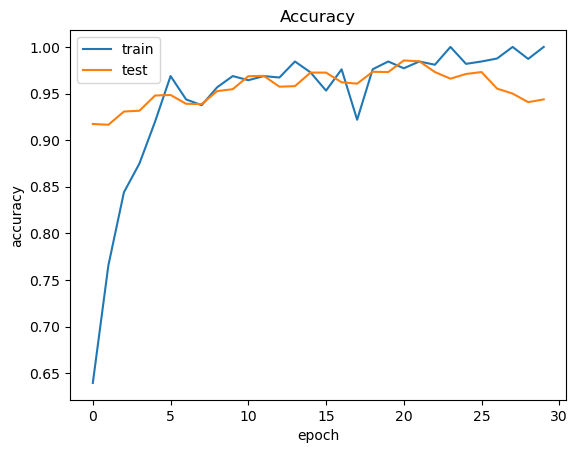

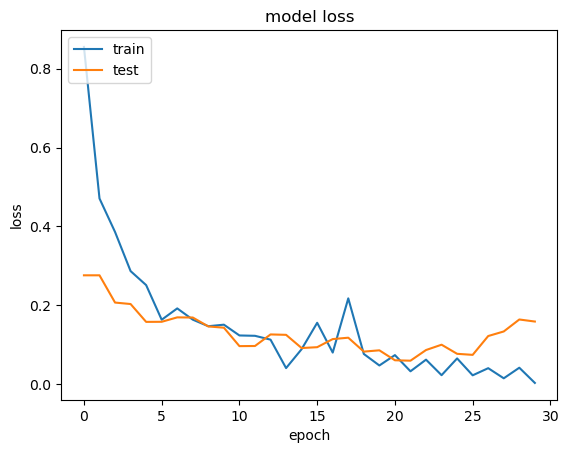

In [21]:
#accuracy and loss plot

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


#loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(classification_report(Y_true, Y_predict))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2999
           1       0.67      0.96      0.79       377

    accuracy                           0.94      3376
   macro avg       0.83      0.95      0.88      3376
weighted avg       0.96      0.94      0.95      3376



In [23]:
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
import keras.utils as image
import kagglehub

